# Overview of Image Text Extraction and Analysis using Qwen-VL-Chat-INT4 and Transformers

This Jupyter notebook demonstrates a process for extracting text from images and analyzing the content using the model Qwen-VL-Chat-INT4. The code includes the following top-level goals:

1. **Environment Setup**: Install all required elements to run the Qwen-VL-Chat-INT4 model, as it's not supported in most of the regular LLM tools.
2. **Multiple Image Loading**: Define a conversation where multiple images can be used sequentially.
4. **Handwriten Text Extraction Instructions**: Prepare instructions for the model to extract text from the images, arranging them by note. 
5. **Assess Few-shot learning capabilities**: Set up the foundations for few-shot learning based on multiple interactions using Qwen-VL-Chat family models.

If you are not using this notebook in a colab/kaggle environment, please make sure to create a virtual environment before executing the code.

Note: Images in this example have been taken from Unplash. Thanks to all content creators (referenced in the file names), to provide such beautiful images.

## Notes on Few-Shot Learning feasibility

According to the information at the [model page]( ):

- Multi-lingual LVLM supporting text recognition: Qwen-VL naturally supports English, Chinese, and multi-lingual conversation, and it promotes end-to-end recognition of Chinese and English bi-lingual text in images.
- Multi-image interleaved conversations: This feature allows for the input and comparison of multiple images, as well as the ability to specify questions related to the images and engage in multi-image storytelling.
- Fine-grained recognition and understanding: Compared to the 224x224 resolution currently used by other open-sourced LVLM, the 448x448 resolution promotes fine-grained text recognition, document QA, and bounding box annotation.

Regarding the resolution of the images:

- Resolution is important for several above evaluations. While most open-sourced LVLM models with 224 resolution are incapable of these evaluations or can only solve these by cutting images, Qwen-VL scales the resolution to 448 so that it can be evaluated end-to-end.

Regarding the inference speed and memory usage, the model context seems to be 8192 tokens, and images take 258 tokens per image. This image size might not be a fixed one, but one dependent on the resolution of the image. This is not completely clear from the documentation, so we will need to comfirm this later on.

In our example, we will use:

- Qwen-VL-Chat: A multimodal LLM-based AI assistant, which is trained with alignment techniques. Qwen-VL-Chat supports more flexible interaction, **such as multiple image inputs, multi-round question answering,** and creative capabilities.



In [1]:
# Install all required packages
!pip install --upgrade pip
!pip install transformers==4.32.0 -q
!pip install accelerate -q
!pip install tiktoken -q
!pip install einops -q
!pip install transformers_stream_generator==0.0.4 -q
!pip install scipy -q
!pip install torchvision -q
!pip install pillow -q
!pip install tensorboard -q
!pip install matplotlib -q
!pip install auto-gptq -q

In [2]:
# Importing the required libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os
from PIL import Image
import IPython.display as display

torch.manual_seed(1234)

/mnt/data/GenAI/vision/Qwen-VL-Chat-Int4/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Image paths
image_file_1 = os.path.join(
        "..",
        "data",
        "external",
        "unsplash",
        "hannah-fleming-hlll-ANkZdIsGpHM-unsplash.jpg",
)

image_file_2 = os.path.join(
        "..",
        "data",
        "external",
        "unsplash",
        "sarah-kilian-yvxw4K9lYKo-unsplash.jpg"
)

image_file_3 = os.path.join(
        "..",
        "data",
        "external",
        "unsplash",
        "nick-fewings-GpplHQ-fyvA-unsplash.jpg"
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen-VL-Chat-Int4", trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen-VL-Chat-Int4", device_map="cuda", trust_remote_code=True).eval()


/mnt/data/GenAI/vision/Qwen-VL-Chat-Int4/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/mnt/data/GenAI/vision/Qwen-VL-Chat-Int4/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


In [9]:
# First turn conversation
initial_task_instructions = """You will perform the task "Notes information extraction" that consists of the following steps:
                    
                    Given one image, extract the relevant information related to the notes (post-it)s including:

                     - The total number of notes in an image.
                     - For each note: ID (auto-generated), position in the image, color, shape, and text on the note

                    The output should be a JSON object, without any additional comments or explanations:

                  This is an example of the expected output for Picture 1: (Do not use this as a template for the output, as the actual output may vary):
                  {
                    "total_notes": 1,
                    "notes": [
                      {
                        "id": "note_1",
                        "position": {
                          "x": 224,
                          "y": 224,
                          "description": "center"
                        },
                        "color": "orange",
                        "shape": "square",
                        "text": "SLOW DOWN A LITTLE?"
                      }
                    ]
                  }

                  This is an example of the expected output for Picture 2: (Do not use this as a template for the output, as the actual output may vary):
                  {
                    "total_notes": 4,
                    "notes": [
                      {
                        "id": "note_1",
                        "position": {
                          "x": 61,
                          "y": 224,
                          "description": "middle left side"
                        },
                        "color": "yellow",
                        "shape": "square",
                        "text": "Stay Home"
                      },
                      {
                        "id": "note_2",
                        "position": {
                          "x": 173,
                          "y": 224,
                          "description": "middle left, near center"
                        },
                        "color": "green",
                        "shape": "square",
                        "text": "Be Safe"
                      },
                      {
                        "id": "note_3",
                        "position": {
                          "x": 285,
                          "y": 224,
                          "description": "middle right, near center"
                        },
                        "color": "orange",
                        "shape": "square",
                        "text": "KEEP YOUR DISTANCE"
                      },
                      {
                        "id": "note_4",
                        "position": {
                          "x": 397,
                          "y": 224,
                          "description": "middle right side"
                        },
                        "color": "pink",
                        "shape": "square",
                        "text": "Don't got out!"
                      }
                    ]
                  }

                Take a deep breath, check the input images picture 1 and picture 2 and the given outputs. Explain the provided outputs based on the input images.              
                """

                    
initial_query = f'Picture 1:<img>{image_file_1}</img>\nPicture 2:<img>{image_file_2}</img>\n{initial_task_instructions}'

response, history = model.chat(tokenizer, query=initial_query, history=None)
print(response)


Picture 1: The image shows a total of 1 note with the text "SLOW DOWN A LITTLE?" written on it. The note is located in the center of the image and is in orange color with a square shape.
Picture 2: The image shows a total of 4 notes with the following text: "Stay Home", "Be Safe", "KEEP YOUR DISTANCE", "Don't go out!". The notes are arranged in a 2x2 grid with each note occupying the center of the corresponding side of the grid. The notes are of different colors and shapes, with "Stay Home" and "Be Safe" being yellow and green respectively, "KEEP YOUR DISTANCE" being orange and "Don't go out!" being pink. The notes are positioned in the following way: "Stay Home" is in the middle left side, "Be Safe" is in the middle left, "KEEP YOUR DISTANCE" is in the middle right, and "Don't go out!" is in the middle right side.


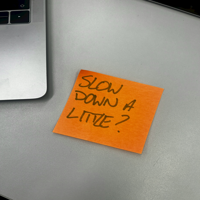

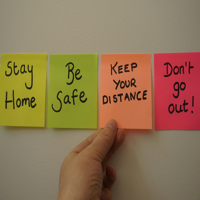

In [7]:
# print a thumbnail of images 1 and 2
display.display(Image.open(image_file_1).resize((200, 200)))
display.display(Image.open(image_file_2).resize((200, 200)))

In [10]:
# Second turn conversation

additional_image_instructions = """Now perform the "Notes information extraction" task in picture 3, following the format provided in the previous examples."""
new_image_query = f'Picture 3:<img>{image_file_3}</img>\n{additional_image_instructions}'
response, history = model.chat(tokenizer, query=new_image_query, history=history)
print(response)

{
 "total notes": 1, "notes": [ { "id": "note_1", "position": { "x": 12, "y": 12, "description": "center" }, "color": "yellow", "shape": "square", "text": "I QUIT!" } ] }


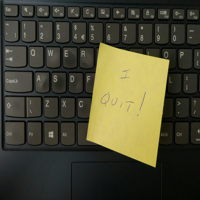

In [ ]:
# print a thumbnail of image 3
display.display(Image.open(image_file_3).resize((200, 200)))

In [ ]:
# Third turn conversation

response, history = model.chat(tokenizer, query='What do pictures 1, 2, 3 have in common?', history=history)
print(response)

The common theme among pictures 1, 2, and 3 is that they all involve the use of sticky notes or post-its to convey a message or convey information.


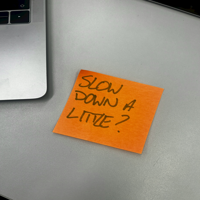

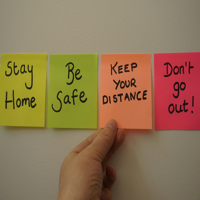

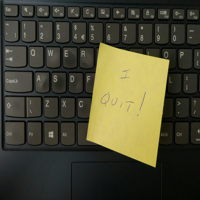

In [ ]:
# print a thumbnail of images 1, 2 and 3
display.display(Image.open(image_file_1).resize((200, 200)))
display.display(Image.open(image_file_2).resize((200, 200)))
display.display(Image.open(image_file_3).resize((200, 200)))